In [56]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import os
import sqlite3
import io
import pickle
import warnings
import sys

import pandas as pd
import numpy as np

import boto3
import sagemaker
import optuna

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
from IPython.display import Image

sys.path.append("/home/ec2-user/SageMaker/customer-churn/")
from src.custom_utils import S3Pickle

## Globals

In [57]:
fig_size = (10, 8)

seed = 12
rs = np.random.RandomState(seed)

warnings.filterwarnings("ignore")

## S3

In [58]:
s3_client = boto3.client("s3")

bucket_name = "yang-ml-sagemaker"
s3_key = "customer_churn"
raw_data_path = os.path.join(s3_key, "raw_data")
train_test_path = os.path.join(s3_key, "train_test")

s3_paths = sagemaker.s3.S3Downloader.list(f"s3://{bucket_name}/{raw_data_path}")
s3_paths[-1]

's3://yang-ml-sagemaker/customer_churn/raw_data/joined_data.csv'

## Data

In [4]:
df = pd.read_csv(s3_paths[-1], index_col=0)
df.shape

(7043, 37)

In [5]:
df.head(5)

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Number of Referrals,Tenure in Months,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Satisfaction Score,Churn Value,CLTV,Churn Category
0,0002-ORFBO,Female,37,No,No,Yes,No,0,2,9,...,Credit Card,65.6,593.30,0.00,0,381.51,3,0,2205,NaN
1,0003-MKNFE,Male,46,No,No,No,No,0,0,9,...,Credit Card,59.9,542.40,38.33,10,96.21,5,0,5414,NaN
2,0004-TLHLJ,Male,50,No,No,No,No,0,0,4,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,1,1,4479,Competitor
3,0011-IGKFF,Male,78,No,Yes,Yes,No,0,1,13,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1,1,3714,Dissatisfaction
4,0013-EXCHZ,Female,75,No,Yes,Yes,No,0,3,3,...,Credit Card,83.9,267.40,0.00,0,22.14,1,1,3464,Dissatisfaction


### Train Test Split

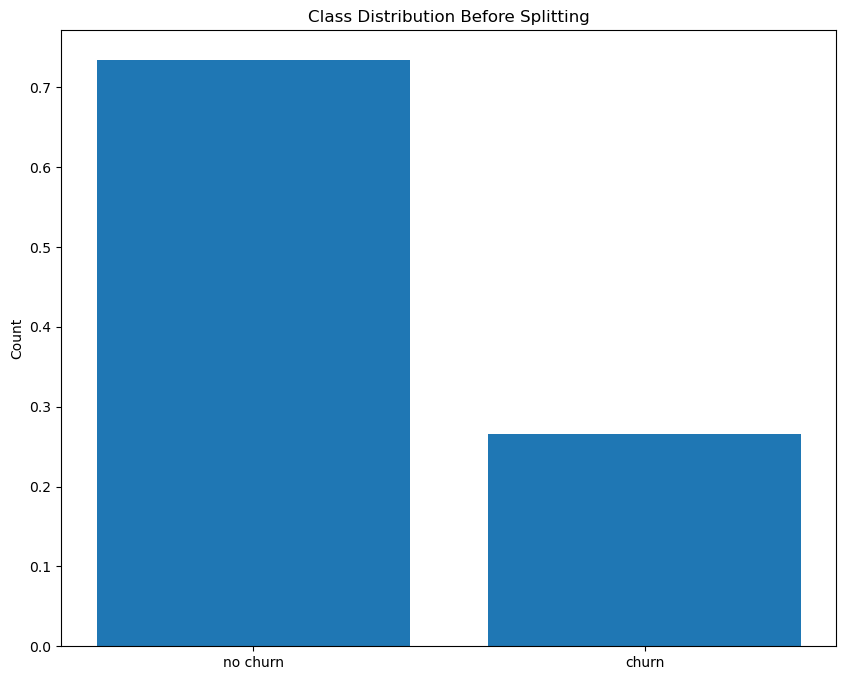

In [48]:
# Class distribution before splitting
fig, ax = plt.subplots(figsize=fig_size)
ax.bar(x=["no churn", "churn"], height=df["Churn Value"].value_counts(normalize=True))
plt.title("Class Distribution Before Splitting")
plt.ylabel("Count")
plt.show();

In [49]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=rs)

for train_index, test_index in sss.split(X, y):
    train, test = df.iloc[train_index], df.iloc[test_index]

train.shape, test.shape

((5634, 37), (1409, 37))

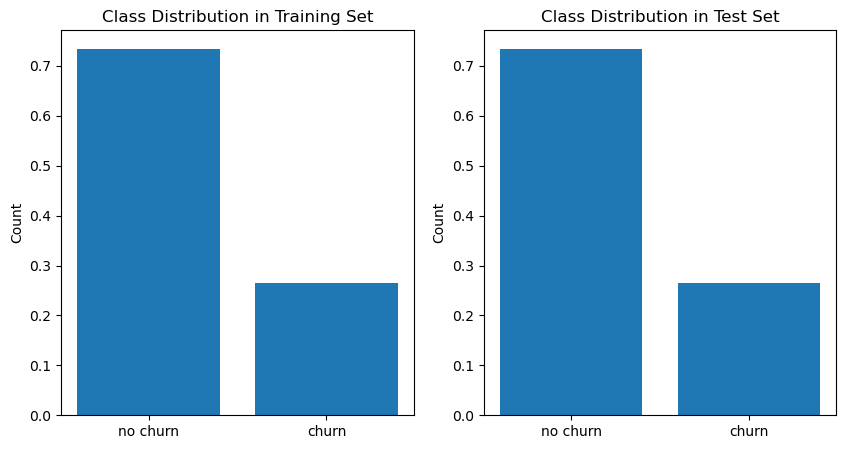

In [50]:
# Class distribution after splitting
train_class_dist = pd.Series(train["Churn Value"]).value_counts(normalize=True)
test_class_dist = pd.Series(test["Churn Value"]).value_counts(normalize=True)

# Set the figure size and create the subplots
fig, (ax_train, ax_test) = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the class distribution for y_train
ax_train.bar(x=["no churn", "churn"], height=train_class_dist)
ax_train.set_title("Class Distribution in Training Set")
ax_train.set_ylabel("Count")

# Plot the class distribution for y_test
ax_test.bar(x=["no churn", "churn"], height=test_class_dist)
ax_test.set_title("Class Distribution in Test Set")
ax_test.set_ylabel("Count")

# Display the plot
plt.show();

### Upload to S3

In [56]:
train.to_csv(f"s3a://{bucket_name}/{train_test_path}/train.csv")
test.to_csv(f"s3a://{bucket_name}/{train_test_path}/test.csv")

sagemaker.s3.S3Downloader.list(f"s3://{bucket_name}/{train_test_path}")

['s3://yang-ml-sagemaker/customer_churn/train_test/test.csv',
 's3://yang-ml-sagemaker/customer_churn/train_test/train.csv']

## Hyperparameter Optimization 

In [ ]:
# Create output directory for sqlite database
!mkdir -p ../output

# Run scriptx
!/home/ec2-user/anaconda3/envs/python3/bin/python /home/ec2-user/SageMaker/customer-churn/src/xgboost_hpo.py --n_trials=100 --k=5

### HPO History Plot

In [72]:
hpo_results_urls = sagemaker.s3.S3Downloader.list(f"s3://{bucket_name}/{s3_key}/hpo")
hpo_results_urls

s3_pickle = S3Pickle(s3_client=s3_client)

study = s3_pickle.download_pickle(
    bucket_name=bucket_name, key_name=os.path.join(s3_key, "hpo/study.pickle")
)

study

['s3://yang-ml-sagemaker/customer_churn/hpo/study.pickle',
 's3://yang-ml-sagemaker/customer_churn/hpo/trial_history.db']

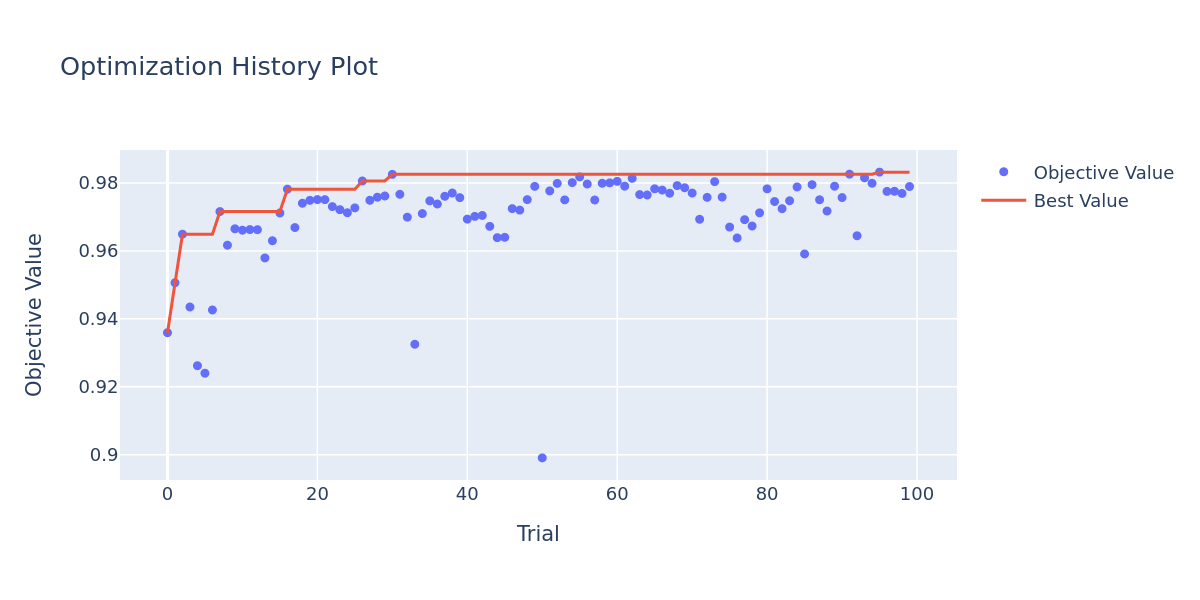

In [69]:
fig = optuna.visualization.plot_optimization_history(study)

# Render as as image
image_bytes = pio.to_image(fig, formåat="png", width=800, height=400, scale=1.5)

Image(image_bytes)

### Parameter Importance Plot

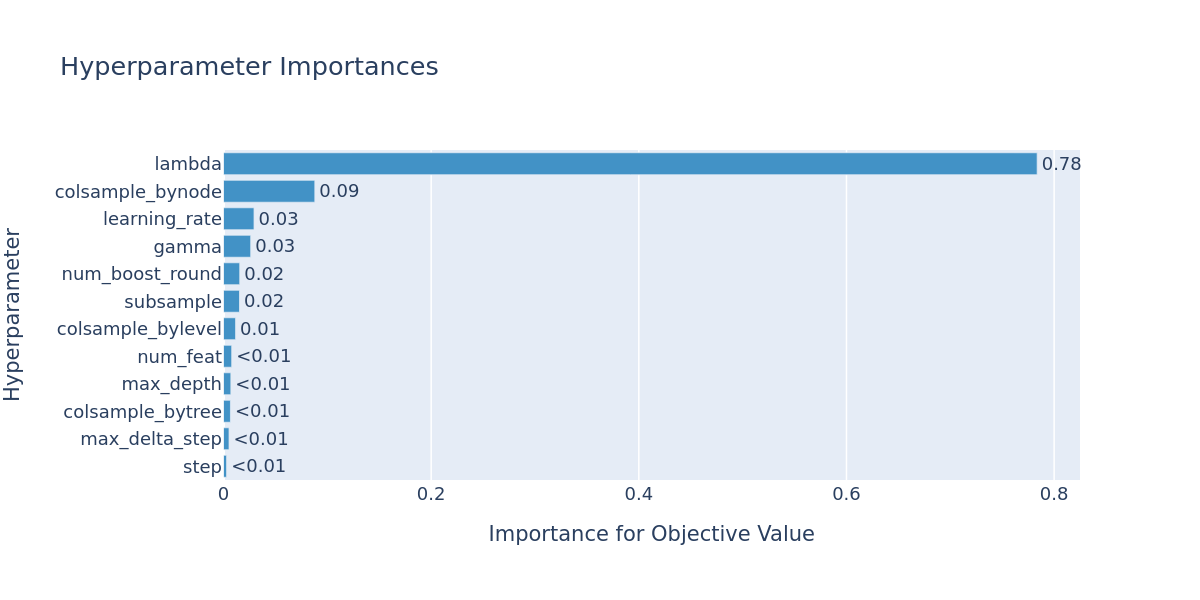

In [70]:
fig = optuna.visualization.plot_param_importances(study)

# Render as as image
image_bytes = pio.to_image(fig, format="png", width=800, height=400, scale=1.5)

Image(image_bytes)

### Parallel Coordinate Plot

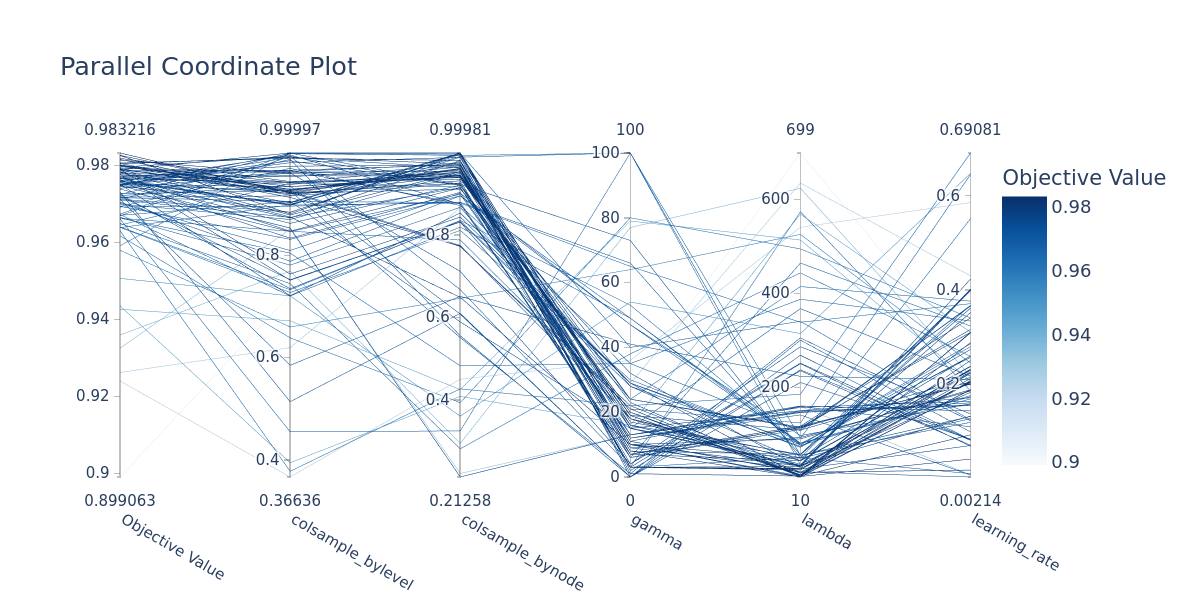

In [71]:
fig = optuna.visualization.plot_parallel_coordinate(
    study,
    params=[
        "lambda",
        "colsample_bynode",
        "learning_rate",
        "colsample_bylevel",
        "gamma",
    ],
)

# Render as as image
image_bytes = pio.to_image(fig, format="png", width=800, height=400, scale=1.5)

Image(image_bytes)

Best parameters:

In [73]:
study.best_params

{'colsample_bylevel': 0.921645063797166,
 'colsample_bynode': 0.9610978659904691,
 'colsample_bytree': 0.33889598945736665,
 'gamma': 3,
 'lambda': 25,
 'learning_rate': 0.22349223791882736,
 'max_delta_step': 1,
 'max_depth': 11,
 'num_boost_round': 1500,
 'num_feat': 60,
 'step': 0.1,
 'subsample': 0.6161079290690729}